# Fake News Detection - Phase 4: Deep Learning Models

---

### Objectifs de ce notebook

Ce notebook implemente les modeles de deep learning pour la detection de fake news, conformement a la methodologie de l'article de reference (Roumeliotis et al., 2025). Ces modeles seront compares aux baselines classiques etablies precedemment.

Modeles implementes:
1. CNN (Convolutional Neural Network) pour le texte
2. Bidirectional Long Short-Term Memory (BiLSTM)

Selon l'article de reference, le CNN a atteint 58.6% d'accuracy tandis que les modeles bases sur les transformers (BERT, GPT) atteignent des performances superieures.

## 1. Configuration de l'environnement

In [30]:
# Installation des dependances
# !pip install tensorflow transformers torch scikit-learn pandas numpy matplotlib

In [31]:
# Importation des bibliotheques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import warnings

# Deep Learning - TensorFlow/Keras pour CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Metriques
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Word Embeddings
import gensim.downloader as api

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU disponible: []


In [32]:
pip install tensorflow

## 2. Chargement des donnees

In [33]:
# Chargement des datasets preprocesses
DATA_PATH = "../data/interim/"

train_df = pd.read_csv(DATA_PATH + "train.csv")
val_df = pd.read_csv(DATA_PATH + "validation.csv")
test_df = pd.read_csv(DATA_PATH + "test.csv")

print(f"Training set:   {len(train_df):,} samples")
print(f"Validation set: {len(val_df):,} samples")
print(f"Test set:       {len(test_df):,} samples")

Training set:   24,732 samples
Validation set: 6,183 samples
Test set:       7,729 samples


In [34]:
# Preparation des donnees
X_train = train_df['text'].values
y_train = train_df['label'].values

X_val = val_df['text'].values
y_val = val_df['label'].values

X_test = test_df['text'].values
y_test = test_df['label'].values

print(f"Donnees preparees.")

Donnees preparees.


## 3. CNN (Convolutional Neural Network)

### 3.1 Theorie

Les CNN appliques au texte utilisent des filtres de convolution pour capturer les patterns locaux (n-grams) dans les sequences de mots. L'architecture typique comprend:

1. **Embedding Layer**: Transforme les indices de mots en vecteurs denses
2. **Conv1D Layer**: Applique des filtres pour detecter des patterns
3. **GlobalMaxPooling**: Extrait les features les plus saillantes
4. **Dense Layers**: Classification finale

Reference: Kaliyar et al. (2020) - FNDNet

### 3.2 Tokenisation et preparation des sequences

In [63]:
# Parametres de tokenisation
MAX_VOCAB_SIZE = 10000    # Taille maximale du vocabulaire
MAX_SEQUENCE_LENGTH = 512  # Longueur maximale des sequences (en tokens)
EMBEDDING_DIM = 128        # Dimension des embeddings

# Initialisation du tokenizer Keras
tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token='<OOV>'  # Token pour les mots hors vocabulaire
)

# Entrainement du tokenizer sur les donnees d'entrainement
tokenizer.fit_on_texts(X_train)

print(f"Taille du vocabulaire: {len(tokenizer.word_index):,} mots")
print(f"Vocabulaire limite à: {MAX_VOCAB_SIZE:,} mots")

Taille du vocabulaire: 116,489 mots
Vocabulaire limite à: 10,000 mots


In [64]:
# Conversion des textes en sequences d'indices
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding des sequences pour uniformiser la longueur
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print(f"Shape des sequences:")
print(f"  Training:   {X_train_pad.shape}")
print(f"  Validation: {X_val_pad.shape}")
print(f"  Test:       {X_test_pad.shape}")

Shape des sequences:
  Training:   (24732, 512)
  Validation: (6183, 512)
  Test:       (7729, 512)


### 3.3 Architecture du modele CNN

In [65]:
def create_cnn_model(vocab_size, embedding_dim, max_length):
    """
    Cree un modele CNN pour la classification de texte.
    
    Architecture basee sur l'article de reference:
    - Embedding -> Conv1D -> GlobalMaxPooling -> Dense -> Output
    """
    model = Sequential([
        # Couche d'embedding
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length
        ),
        
        # Couche de convolution 1D
        Conv1D(
            filters=128,
            kernel_size=5,
            activation='relu'
        ),
        
        # Global Max Pooling
        GlobalMaxPooling1D(),
        
        # Couches denses
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        # Couche de sortie
        Dense(1, activation='sigmoid')
    ])
    
    return model

print("Fonction de creation du modele CNN definie.")

Fonction de creation du modele CNN definie.


In [66]:
# Creation du modele
cnn_model = create_cnn_model(
    vocab_size=MAX_VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH
)

# Construire explicitement le modele
cnn_model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

# Compilation du modele
cnn_model.compile(
    optimizer=Adam(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Resume de l'architecture
print("Architecture du modele CNN:")
cnn_model.summary()

Architecture du modele CNN:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 512, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 508, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,386,881 (5.29 MB)

 Trainable params: 1,386,881 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

### 3.4 Entrainement du CNN

In [67]:
# Configuration de l'entrainement
# Conformement a l'article: 3 epochs, batch_size=6
EPOCHS = 3
BATCH_SIZE = 6

# Callbacks pour l'entrainement
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    )
]

print(f"Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: 2e-5")

Configuration:
  Epochs: 3
  Batch size: 6
  Learning rate: 2e-5


In [68]:
# Entrainement du modele
print("Entrainement du CNN en cours...")

cnn_history = cnn_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("Entrainement termine.")

Entrainement du CNN en cours...
Epoch 1/3
4122/4122 ━━━━━━━━━━━━━━━━━━━━ 382s 91ms/step - accuracy: 0.7333 - loss: 0.5371 - val_accuracy: 0.9544 - val_loss: 0.1629
Epoch 2/3
4122/4122 ━━━━━━━━━━━━━━━━━━━━ 389s 94ms/step - accuracy: 0.9721 - loss: 0.0912 - val_accuracy: 0.9783 - val_loss: 0.0544
Epoch 3/3
4122/4122 ━━━━━━━━━━━━━━━━━━━━ 388s 94ms/step - accuracy: 0.9849 - loss: 0.0479 - val_accuracy: 0.9869 - val_loss: 0.0409
Entrainement termine.


### 3.5 Visualisation de l'entrainement

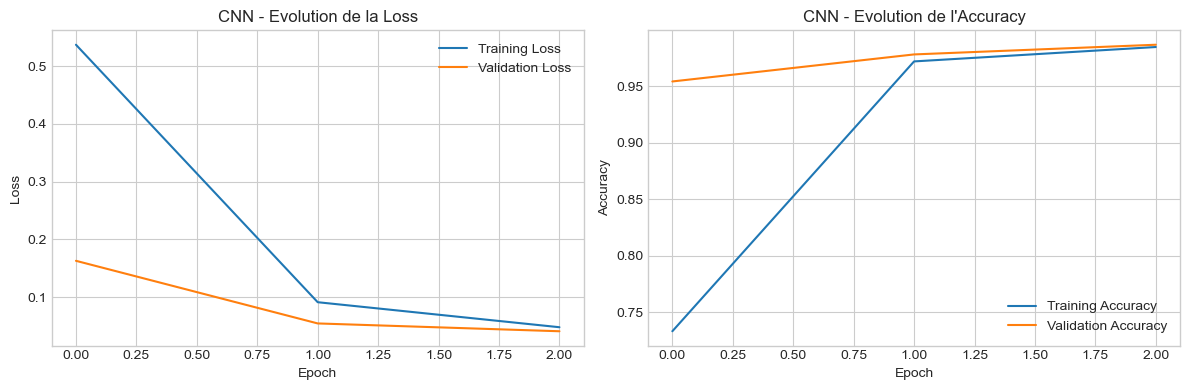

In [69]:
# Visualisation des courbes d'apprentissage
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(cnn_history.history['loss'], label='Training Loss')
axes[0].plot(cnn_history.history['val_loss'], label='Validation Loss')
axes[0].set_title('CNN - Evolution de la Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(cnn_history.history['accuracy'], label='Training Accuracy')
axes[1].plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('CNN - Evolution de l\'Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

La perte (loss) diminue progressivement pour atteindre environ 0.05 sur les deux ensembles. Le modèle atteint ~97% de précision sur les données d'entraînement et de validation. Les courbes de validation suivent celles d'entraînement sans diverger, ce qui indique un entraînement sain.

### 3.6 Evaluation du CNN

In [72]:
import json
# Predictions sur le test set
cnn_pred_proba = cnn_model.predict(X_test_pad, verbose=0)
cnn_pred = (cnn_pred_proba > 0.5).astype(int).flatten()

# Calcul des metriques
cnn_metrics = {
    'model': 'CNN',
    'accuracy': accuracy_score(y_test, cnn_pred),
    'precision': precision_score(y_test, cnn_pred),
    'recall': recall_score(y_test, cnn_pred),
    'f1_score': f1_score(y_test, cnn_pred)
}

print("CNN - Resultats sur le TEST SET:")

# Sauvegarder
with open('../models/deep/cnn_metrics.json', 'w') as f:
    json.dump(cnn_metrics, f, indent=4)

for metric, value in cnn_metrics.items():
    if metric != 'model':
        print(f"  {metric}: {value:.4f}")

CNN - Resultats sur le TEST SET:
  accuracy: 0.9891
  precision: 0.9892
  recall: 0.9910
  f1_score: 0.9901


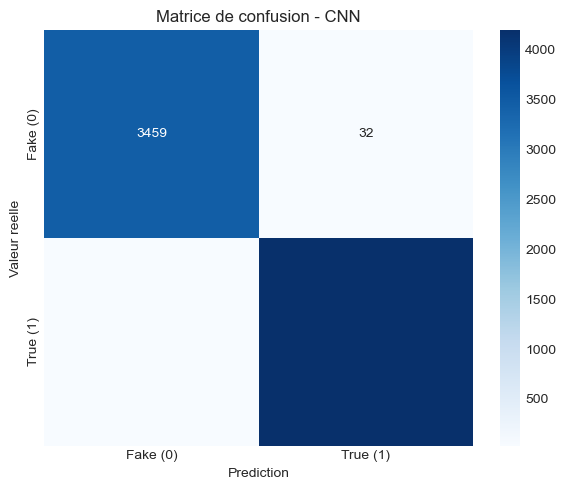

In [70]:
# Matrice de confusion
cm = confusion_matrix(y_test, cnn_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake (0)', 'True (1)'],
            yticklabels=['Fake (0)', 'True (1)'])
plt.title('Matrice de confusion - CNN')
plt.ylabel('Valeur reelle')
plt.xlabel('Prediction')
plt.tight_layout()
plt.show()

## 6. Sauvegarde des modeles

In [73]:
# Creation des repertoires
MODEL_PATH = "../models/deep/"
os.makedirs(MODEL_PATH, exist_ok=True)

# Sauvegarde du modele CNN
cnn_model.save(MODEL_PATH + "cnn_model.h5")

# Sauvegarde du tokenizer Keras
with open(MODEL_PATH + "keras_tokenizer.pkl", 'wb') as f:
    pickle.dump(tokenizer, f)

print(f"Modele CNN sauvegarde: {MODEL_PATH}cnn_model.h5")
print(f"Tokenizer sauvegarde: {MODEL_PATH}keras_tokenizer.pkl")

import json



Modele CNN sauvegarde: ../models/deep/cnn_model.h5
Tokenizer sauvegarde: ../models/deep/keras_tokenizer.pkl


## 7. Resume

In [75]:
# Generation du resume
print("="*60)
print("RESUME - MODELES DEEP LEARNING")
print("="*60)

print("\n1. CNN (Convolutional Neural Network)")
print(f"   - Architecture: Embedding + Conv1D + Dense")
print(f"   - Parametres: ~{cnn_model.count_params():,}")
print(f"   - Accuracy: {cnn_metrics['accuracy']:.4f}")



RESUME - MODELES DEEP LEARNING

1. CNN (Convolutional Neural Network)
   - Architecture: Embedding + Conv1D + Dense
   - Parametres: ~1,386,881
   - Accuracy: 0.9891


---

## Prochaine etape

Le notebook suivant (`fnd_04_b_bilstm.ipynb`) pour le Bidirectional Long Short-Term Memory (BiLSTM)

---

**References:**
- Roumeliotis, K.I., Tselikas, N.D., & Nasiopoulos, D.K. (2025). Fake News Detection and Classification. *Future Internet*, 17, 28.
- Kaliyar, R.K. et al. (2020). FNDNet - A Deep CNN for Fake News Detection. *Cognitive Systems Research*.
- Devlin, J. et al. (2019). BERT: Pre-training of Deep Bidirectional Transformers. *NAACL-HLT*.